In [99]:
import torch
import glob
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision.utils import save_image
from torchvision import datasets
from torchvision.transforms import ToTensor, Lambda, Compose
import matplotlib.pyplot as plt
import torchvision.transforms as transforms 
from PIL import Image,ImageOps
#from base.base_data_loader import BaseDataLoader
#from data_loader.dataset import Dataset
from torch.utils.data.dataloader import default_collate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale

from matplotlib.pyplot import figure
from matplotlib.pyplot import plot
from matplotlib.pyplot import xlabel
from matplotlib.pyplot import ylabel
from matplotlib.pyplot import show

import numpy as np
import pandas as pd
import os
import cv2
#from tqdm import tqdm

In [2]:
#DATA_PATH = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/data.xlsx'
#IMG_DIR = '/kaggle/input/ocular-disease-recognition-odir5k/ODIR-5K/ODIR-5K/Training Images/'

DATA_PATH = '../archive/ODIR-5K/ODIR-5K/data.xlsx'
#IMG_DIR = 'ODIR-5K/ODIR-5K/TRAINING/'
IMG_DIR = '../archive/preprocessed_images'

In [27]:
data = pd.read_excel(DATA_PATH)

diagnostic_keyphrases = {'N': ['normal fundus'], 
 'D': ['nonproliferative retinopathy',
  'non proliferative retinopathy','mild nonproliferative retinopathy',
  'proliferative retinopathy','diabetic retinopathy'],
 'G': ['glaucoma'],
 'C': ['cataract'],
 'A': ['age-related macular degeneration'],
 'H': ['hypertensive'],
 'M': ['myopi'],
 'O': ['macular epiretinal membrane',
  'epiretinal membrane',
  'drusen',
  'myelinated nerve fibers',
  'vitreous degeneration',
  'refractive media opacity',
  'spotted membranous change',
  'tessellated fundus',
  'maculopathy',
  'chorioretinal atrophy',
  'branch retinal vein occlusion',
  'retinal pigmentation',
  'white vessel',
  'post retinal laser surgery',
  'epiretinal membrane over the macula',
  'retinitis pigmentosa',
  'central retinal vein occlusion',
  'optic disc edema',
  'post laser photocoagulation',
  'retinochoroidal coloboma',
  'atrophic change',
  'optic nerve atrophy',
  'old branch retinal vein occlusion',
  'depigmentation of the retinal pigment epithelium',
  'chorioretinal atrophy with pigmentation proliferation',
  'central retinal artery occlusion',
  'old chorioretinopathy',
  'pigment epithelium proliferation',
  'retina fold',
  'abnormal pigment ',
  'idiopathic choroidal neovascularization',
  'branch retinal artery occlusion',
  'vessel tortuosity',
  'pigmentation disorder',
  'rhegmatogenous retinal detachment',
  'macular hole',
  'morning glory syndrome',
  'atrophy',
  'laser spot',
  'arteriosclerosis',
  'asteroid hyalosis',
  'congenital choroidal coloboma',
  'macular coloboma',
  'optic discitis',
  'oval yellow-white atrophy',
  'wedge-shaped change',
  'wedge white line change',
  'retinal artery macroaneurysm',
  'retinal vascular sheathing',
  'suspected abnormal color of  optic disc',
  'suspected retinal vascular sheathing',
  'suspected retinitis pigmentosa',
  'silicone oil eye']}

LeftText=[]
for i, row in data.iterrows():
    text=row['Left-Diagnostic Keywords']
    Listecle=[]
    for cle, valeur in diagnostic_keyphrases.items():
        valeur = diagnostic_keyphrases.get (cle)
        for keyword in valeur:
            if keyword in text:
                Listecle.append (cle)
           
    Listecle=list(set(Listecle))
    LeftText.append (Listecle)

data['Left Text']= LeftText


RightText=[]
for i, row in data.iterrows():
    text=row['Right-Diagnostic Keywords']
    Listecle=[]
    for cle, valeur in diagnostic_keyphrases.items():
        valeur = diagnostic_keyphrases.get (cle)
        for keyword in valeur:
            if keyword in text:
                Listecle.append (cle)
           
    Listecle=list(set(Listecle))
    RightText.append (Listecle)

data['Right Text']= RightText
key_columns = ['ID', 'Patient Age','Patient Sex','Left-Fundus','Right-Fundus','N','D','G','C','A','H','M','O','Left Text','Right Text'] 
data=data [key_columns]
data.head()

df=data
df.to_csv('full_df.csv', mode='a', header=key_columns, index=False, encoding='utf-8')


In [28]:
IMG_SIZE = 512

In [5]:
print (len(data))

3500


In [6]:


def preprocess_image_Crop(image): 
    image=np.asarray (image)
    # Remove vertical black borders (the image must be already normalized)
    sums = image.sum(axis=0)
    sums = sums.sum(axis=1)
    filter_arr = []
    for s in sums:
        if s == 0:
            filter_arr.append(False)
        else:
            filter_arr.append(True)
    image = image[:, filter_arr]
    
    # Crop to a square shape
    h = image.shape[0]
    w = image.shape[1]    
    
    if h < w:
        x = (w - h)//2
        image = image[:, x:x+h, :]        
    elif h > w:
        x = (h - w)//2
        image = image[x:x+w, :, :]           
    else:
        pass
    
    image=Image.fromarray (image)
    return image

def preprocess_image_Resize(image):
    image=np.asarray (image)
    norm_img = np.zeros(image.shape)
    # normalisation 0 ou 1
    norm_img = cv2.normalize(image,  norm_img, 0, 255, cv2.NORM_MINMAX)

    # redimension de l'image pour avoir meme dimension entre toutes les images (à cause image resolution differentes)
    # et conversion de la couleur de l'image car par defaut cv2 lit image en couleur bleue
    # dans le resize, le ration = 1 par defaut car hauteur pixel = largeur pixel
    image = cv2.resize(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), (IMG_SIZE, IMG_SIZE))

    image=Image.fromarray (image)
    return image

def scaleRadius (img, scale):
    toto=int(img.shape[0]/2)
    x=img[toto,:,:].sum (1)
    r=(x>x.mean()/10).sum()/2
    s=scale * 1.0/r
    return cv2.resize (img,(0,0), fx=s , fy=s )

# implementation pseudo-code Ben Graham
def preprocess_image_Ben (image):
    
    image=np.asarray (image)

    scale =320

    
    # enleve les bordures
    # #image = preprocess_image_crop(norm_img)

    #redimensionnement de l'image à un rayon donné
    image=scaleRadius (image, scale)
    
    #on soustrait la couleur moyenne pour la mapper sur 50% de gris de façon à mieux faire ressortir les constrastes
    image=cv2.addWeighted (image ,4,cv2.GaussianBlur (image,(0,0),scale/30),-4 ,128)
   
   
    #on enleve 10% des bordures
    b=np.zeros(image.shape)

    cv2.circle(b,(int(image.shape[1]/2), int(image.shape[0]/2)),int(scale * 0.9),(1,1,1),-1,8,0)
    #image=image*b+128*(1-b)
    
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image=Image.fromarray (image)
    
    return image

def to_grayscale(image):
    #suppression des bordures
    # passage en noir et blanc
    #image=np.asarray (image)
    image=ImageOps.grayscale(image)
    #image=Image.fromarray (image)
    return image



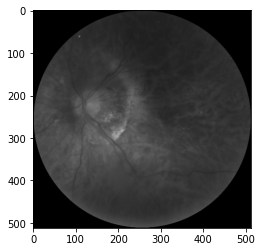

In [7]:
file_name = str(13) + '_left.jpg'

filename = glob.glob(os.path.join(IMG_DIR,file_name))
image = Image.open('12_left.jpg')
image=preprocess_image_Crop(image)
image=to_grayscale(image)
image=preprocess_image_Resize(image)

image.save(str(810)+"_"+file_name)
plt.imshow  (image)
#plt.imshow  (image, cmap='gray')
plt.show ()


In [78]:
class Dataset(torch.utils.data.Dataset):
    'Characterizes a dataset for PyTorch'
    def __init__(self, data_dir,transform):
        'Initialization'

        """
        to_drop = ['ID', 'Patient Age', 'Patient Sex', 'Left-Fundus', 'Right-Fundus',
           'Left-Diagnostic Keywords', 'Right-Diagnostic Keywords', 'N', 'D', 'G',
           'C', 'A', 'H', 'M', 'O', 'filepath', 'target']
        data = data.drop(columns = to_drop)
        """

        data = pd.read_csv('full_df.csv')
  
        my_dir = data_dir+'preprocessed_images/'
  
        my_list = glob.glob(os.path.join(my_dir,'*.jpg'))
        
        ListeMaladie=["['N']", "['D']", "['G']", "['C']","['A']", "['H']","['M']","['O']"]

        left_labels_list=[]
        right_labels_list=[]
        left_name_list=[]
        right_name_list =[]
    
        # test si maladie unique sur un oeil sinon on rejete la donnée y,X
        for i in range (len (data)):
            if data['Left Text'][i] in ListeMaladie:
                left_labels_list.append(data['Left Text'][i])
                left_name_list.append(data['Left-Fundus'][i])
                
            #if data['Right Text'][i] in ListeMaladie:
            #    right_labels_list.append (data['Right Text'][i])
            #    right_name_list.append (data['Right-Fundus'][i])
            
        print ("label left", len(left_labels_list))
        print ("label right", len(right_labels_list))
        filename_list = np.concatenate((right_name_list, left_name_list), axis=None)
        labels_list = np.concatenate((right_labels_list, left_labels_list), axis=None)
        
        self.labels = labels_list
        self.list_IDs = filename_list
        self.transform = transform


    def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

    def __getitem__(self, index):
        """
        'Generates one sample of data'
        print("ICI")
        # Select sample
        ID = self.list_IDs[index]
        # Load data and get label
        X = torch.load('data/preprocessed_images/' + ID)
        y = self.labels[ID]
        return X, y
        """
        ID = self.list_IDs[index]
        img_path = 'preprocessed_images/' + ID
        print("processing", img_path)
        img = Image.open(img_path)

        img_transformed = self.transform(img)


        labels_unique = np.unique(self.labels)
      
        label = self.labels[index]
        label = np.where(labels_unique == label)[0][0]
        
        X=img_transformed
        y=label
   
        return X, y


my_transforms_gray_scale = transforms.Compose ([
    to_grayscale,
    transforms.ToTensor(),
    transforms.Normalize ((0.5),(0.5))
])

my_transforms_ben = transforms.Compose ([
    preprocess_image_Ben,
    preprocess_image_Resize,
    preprocess_image_Crop,
    transforms.ToTensor(),
    transforms.Normalize (mean=[0.485,0.456,0.406],
                          std=[0.229,0.224,0.225])
])

my_transforms_normal = transforms.Compose ([
    preprocess_image_Resize,
    transforms.ToTensor(),
    transforms.Normalize (mean=[0.485,0.456,0.406],
                          std=[0.229,0.224,0.225])
])

#dataset=Dataset(data_dir='', transform=my_transforms)
#
#
#cpt=0
#for img, label in dataset:
#    print ("label",label)
    


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


label left 3235
label right 0
XXXXXXXXXXXXXXX 3235
taille 3235
processing preprocessed_images/0_left.jpg
<class 'torch.Tensor'>


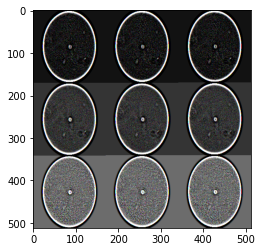

processing preprocessed_images/1_left.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


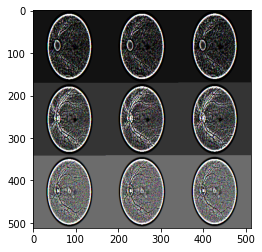

processing preprocessed_images/3_left.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


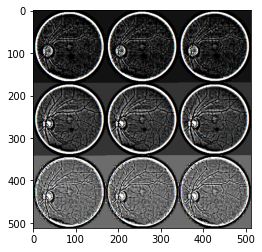

processing preprocessed_images/4_left.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


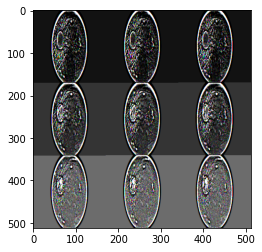

processing preprocessed_images/5_left.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


<class 'torch.Tensor'>


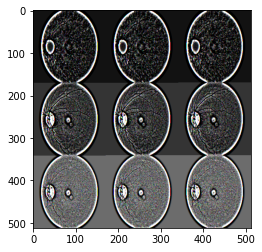

processing preprocessed_images/6_left.jpg
<class 'torch.Tensor'>


KeyboardInterrupt: 

<Figure size 432x288 with 0 Axes>

In [79]:
dataset=Dataset(data_dir='', transform=my_transforms_ben)
#dataset=Dataset(data_dir='', transform=my_transforms_gray_scale)
#dataset=Dataset(data_dir='', transform=my_transforms_normal)

print ("taille", len(dataset))

for img, label in dataset:
    print (type(img))
    #plt.imshow  (img, cmap='gray')
    img=img.reshape(512,512,3)

    plt.imshow  (img.numpy())
    plt.show ()

  


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


processing preprocessed_images/4369_left.jpg
type <class 'torch.Tensor'>
shape : 3


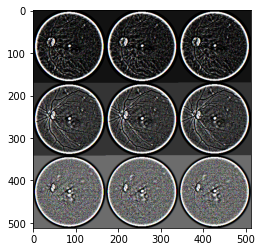

torch.Size([512, 512, 3])


In [83]:

training_data_size=0.8
train_size=int(training_data_size * len(dataset))
test_size=len(dataset) - train_size

train_dataset, test_dataset=torch.utils.data.random_split(dataset, [train_size,test_size])

#for img, label in train_dataset:
#    print (img.shape)
#    print (type(img))
#    img=img.reshape(512,512,3)
#    plt.imshow  (img.numpy())
#    plt.show ()

train_loader= DataLoader(train_dataset, num_workers=0, shuffle=True)
test_loader= DataLoader(test_dataset, num_workers=0, shuffle=False)


#for (image_batch, labels_batch) in enumerate (train_loader):
image_batch, labels_batch=next(iter(train_loader))
print("type", type(image_batch))
firstimage=image_batch[0]
print("shape :", firstimage.shape[0])
#img=img.reshape(512,512,3)
#plt.imshow  (img.numpy())
firstimage=firstimage.reshape(512,512,3)
plt.imshow(firstimage.numpy())
plt.show ()
print(firstimage.shape)

        

        
        

In [101]:
for batch_idx, (data, target) in enumerate(train_loader):
    data=data.reshape (1,3*512*512)
    pca_object=PCA().fit(data)
figure(1, figsize=(6.3), dpi=300)
plot(obj.explained_variance_, linewidth=2)
xlabel('Component')
ylabel('Explained Variances')
show()

        

processing preprocessed_images/4095_left.jpg
processing preprocessed_images/458_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4540_left.jpg
processing preprocessed_images/2348_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/2161_left.jpg
processing preprocessed_images/4172_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/3446_left.jpg
processing preprocessed_images/2551_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/1036_left.jpg
processing preprocessed_images/4650_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/3015_left.jpg
processing preprocessed_images/4129_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/990_left.jpg
processing preprocessed_images/406_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/2665_left.jpg
processing preprocessed_images/4502_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4059_left.jpg
processing preprocessed_images/4036_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/719_left.jpg
processing preprocessed_images/1268_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4325_left.jpg
processing preprocessed_images/2134_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4555_left.jpg
processing preprocessed_images/2782_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/451_left.jpg
processing preprocessed_images/1600_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/2707_left.jpg
processing preprocessed_images/2817_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/965_left.jpg
processing preprocessed_images/832_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/237_left.jpg
processing preprocessed_images/4237_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/3288_left.jpg
processing preprocessed_images/934_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4386_left.jpg
processing preprocessed_images/1220_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4624_left.jpg
processing preprocessed_images/4676_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4263_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/1590_left.jpg
processing preprocessed_images/1640_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/662_left.jpg
processing preprocessed_images/2704_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/4679_left.jpg
processing preprocessed_images/3427_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/2343_left.jpg
processing preprocessed_images/951_left.jpg


/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/sklearn/decomposition/_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


processing preprocessed_images/732_left.jpg
processing preprocessed_images/2994_left.jpg


IndexError: tuple index out of range